In [1]:
import dolfin as dl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.optimize import minimize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

np.random.seed(2)
torch.manual_seed(2)

# Create the Network

In [2]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 1)
        self.apply(self._init_weights)
        
        self.fc1.weight.requires_grad = True
        self.fc1.bias.requires_grad = True
        self.fc2.weight.requires_grad = True
        self.fc2.bias.requires_grad = True
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.uniform_()
            if module.bias is not None:
                module.bias.data.zero_()

        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    

# Testing model

In [3]:
model = NN()
# x = torch.tensor([1.], dtype=torch.float32, requires_grad=True)
# y = model(x).sum()
# y.backward(torch.ones_like(y))
# # y.backward()
# print(model.fc1.weight.grad)
# print(model.fc1.bias.grad)
# print(model.fc2.weight.grad)
# print(model.fc2.bias.grad)
# print(x, x.grad)
# print(y)

# model.zero_grad()

# Set device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creating component needed for model

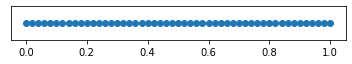

In [5]:
# number of elements for training and testing data
n_train = 50
n_test  = 101

# Create mesh for training and testing data
mesh_train = dl.UnitIntervalMesh(n_train)
mesh_test = dl.UnitIntervalMesh(n_test)

# Create vector version of mesh
mesh_vec = np.linspace(0,1,n_train)

# Define the function space
Vh = dl.FunctionSpace(mesh_train, 'Lagrange', 1)

# Show the mesh
dl.plot(mesh_train)
plt.show()



# Boundary information

In [6]:
def ud_boundary(x, on_boundary):
    return on_boundary

# Define boundary conditions
ud = dl.Constant('0.0')
bc = dl.DirichletBC(Vh, ud, ud_boundary)



# FEM model


In [7]:
class FEM_function:
    def __init__(self, Vh, mesh, bc):
        self.Vh = Vh
        self.coords = torch.tensor(mesh_train.coordinates(), dtype=torch.float32, requires_grad=True)
        self.bc = bc
        
        # Define variational problem
        self.uh = dl.TrialFunction(Vh)
        self.vh = dl.TestFunction(Vh)
        self.M = dl.assemble( dl.inner(self.uh, self.vh)*dl.dx(self.Vh) )
        
        self.m_vector = dl.Vector()
        self.u = dl.Vector()
        self.p = dl.Vector()
        self.M.init_vector(self.m_vector, 0)
        self.M.init_vector(self.u, 0)
        self.M.init_vector(self.p, 0)
        
        self.ud = None
        self.m_fun = None
        
    def forward_data(self, m, f_expr, noise_lvl, add_noise = False):
        Kform = m * dl.inner(dl.grad(self.uh), dl.grad(self.vh))*dl.dx(self.Vh)
        K, self.f = dl.assemble_system(Kform, f_expr*self.vh*dl.dx(self.Vh), self.bc)
        solver = dl.LUSolver()
        solver.set_operator(K)
        
        solver.solve(self.u, self.f)
        
        self.ud = dl.Vector()
        self.M.init_vector(self.ud, 0)        
        self.ud.axpy(1.,self.u)
        
        if add_noise is True:
            uL2 = dl.norm(self.u, 'L2')
            noise = dl.Vector()
            M.init_vector(noise, 0)   
            noise.set_local( noise_lvl * uL2 *np.random.randn(Vh.dim()))
            self.ud.axpy(1.,noise)
        
        return self.u, self.ud
    
    def extract_m(self, model):
#         print(self.coords.dtype)
        self.m_vector.set_local(model(self.coords).detach().numpy())
        return dl.Function(self.Vh, self.m_vector)

    def calc_NN_grad(self, model):
        x = torch.tensor([1.], dtype=torch.float32, requires_grad=True)
        y = model(x)
        y.backward()

        gradients = np.concatenate([p.grad.view(-1).detach().numpy() for p in model.parameters()])

        model.zero_grad()
        
        return gradients
    
    def update_Systems(self, model):
        self.m_fun = self.extract_m(model)
        Kform   = self.m_fun * dl.inner(dl.grad(self.uh), dl.grad(self.vh))*dl.dx(self.Vh)
        Kformt  = self.m_fun * dl.inner(dl.grad(self.vh), dl.grad(self.uh))*dl.dx(self.Vh)
        
        self.K, _ = dl.assemble_system(Kform, dl.Constant(0.)*self.vh*dl.dx(self.Vh), self.bc)
        self.Kt, _ = dl.assemble_system(Kformt, dl.Constant(0.)*self.vh*dl.dx(self.Vh), self.bc)
        
        self.solver = dl.LUSolver()
        self.solver.set_operator(self.K)
        self.solvert = dl.LUSolver()
        self.solvert.set_operator(self.Kt)
       
    def forward(self, model):
        self.update_Systems(model)
        
        self.solver.solve(self.u,self.f)
        
        return torch.tensor(self.u.get_local(), dtype=torch.float32, requires_grad=True)
        
    def adjoint(self):
        
        rhs = dl.Vector()
        self.M.init_vector(rhs, 0)
        rhs.axpy(-1., self.M * (self.u - self.ud))
        
        self.solver.solve(self.p, rhs)
        
        return self.p
    
    def cost(self, model):
        c = 0
        _ = self.forward(model)
        
        c = .5 * np.inner(self.M * (self.u - self.ud),(self.u - self.ud))
        
        return c
    
    def grad(self, model):
        _ = self.forward(model)
        _ = self.adjoint()
        
        u_fun = dl.Function(self.Vh, self.u)
        Fm = dl.assemble(dl.inner(dl.grad(u_fun), dl.grad(self.vh))*dl.dx(self.Vh))
        Jm = dl.assemble(dl.inner(dl.Constant(0.), dl.Constant(0.))*dl.dx(self.Vh))
        
        return (np.inner(self.p, Fm) + Jm) * self.calc_NN_grad(model)

# Create data

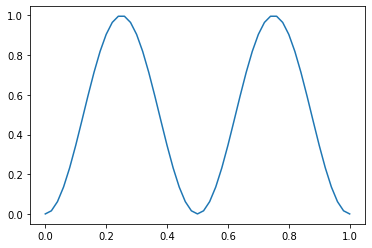

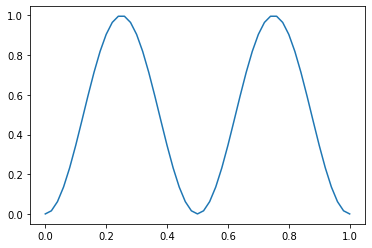

In [8]:
noise_lvl = 0.02

# True m
m_true = dl.Constant(1.)
mx = dl.Constant(0.0)

# True solution and derivatives
utrue = dl.Expression('sin(2*pi*x[0]) * sin(2*pi*x[0])', degree=3)
ux = dl.Expression('4 * pi * sin(2*pi*x[0]) * cos(2*pi*x[0])', degree=3)
uxx = dl.Expression('-8*pi*pi*( sin(2*pi*x[0]) * sin(2*pi*x[0]) - cos(2*pi*x[0]) * cos(2*pi*x[0]) )', degree=3)

f = -mx*ux - m_true*uxx

FEM_model = FEM_function(Vh, mesh = mesh_train, bc = bc)

uapprox, u_noise = FEM_model.forward_data(m_true, f, noise_lvl, add_noise=False)
data = torch.from_numpy(u_noise.get_local())
uapprox = dl.Function(Vh, uapprox)
u_noise = dl.Function(Vh, u_noise)

dl.plot(uapprox)
plt.show()
dl.plot(u_noise)
plt.show()



# Create an instance of the network

In [19]:
model = NN()


# Optimize and Training function

In [20]:
# Define the training loop
def train(params):
    # Update the neural network weights
    with torch.no_grad():
        net_params = torch.tensor(params, dtype=torch.float32).reshape(-1, 1)
        current_param_idx = 0
        for p in model.parameters():
            p.data = net_params[current_param_idx:current_param_idx+p.numel()].reshape(p.shape)
            current_param_idx += p.numel()
        
    # Compute the predictions and loss
    loss = FEM_model.cost(model)
    grads = FEM_model.grad(model)
    grads = grads.astype('float64') # convert to the correct data type
    return loss, grads

# Define the optimizer
def optimize(params):
    loss, grads = train(params)
    return loss, grads



# Train model

In [21]:
# Initialize the weight parameter and optimize it with scipy
params0 = np.concatenate([p.view(-1).detach().numpy() for p in model.parameters()])
bounds = [(None, None)]

print(params0)

for epoch in range(100):
    result = minimize(optimize, params0, jac=True, method='L-BFGS-B', tol = 1e-6)
    params0 = result.x
    
print(params0)

[0.55552906 0.9627685  0.7535962  0.         0.         0.
 0.07267046 0.6462661  0.9804371  0.        ]
[ 5.55529057e-01  9.62768484e-01  7.53596170e-01 -1.23599563e-09
 -1.09918401e-08 -1.66754963e-08  7.26704503e-02  6.46266086e-01
  9.80437087e-01 -1.70082260e-08]


# Show results

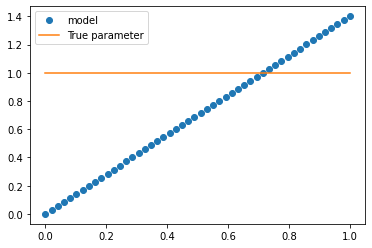

tensor([[-1.7092e-08],
        [ 2.8601e-02],
        [ 5.7201e-02],
        [ 8.5802e-02],
        [ 1.1440e-01],
        [ 1.4300e-01],
        [ 1.7160e-01],
        [ 2.0020e-01],
        [ 2.2880e-01],
        [ 2.5741e-01],
        [ 2.8601e-01],
        [ 3.1461e-01],
        [ 3.4321e-01],
        [ 3.7181e-01],
        [ 4.0041e-01],
        [ 4.2901e-01],
        [ 4.5761e-01],
        [ 4.8621e-01],
        [ 5.1481e-01],
        [ 5.4341e-01],
        [ 5.7201e-01],
        [ 6.0061e-01],
        [ 6.2921e-01],
        [ 6.5781e-01],
        [ 6.8641e-01],
        [ 7.1501e-01],
        [ 7.4362e-01],
        [ 7.7222e-01],
        [ 8.0082e-01],
        [ 8.2942e-01],
        [ 8.5802e-01],
        [ 8.8662e-01],
        [ 9.1522e-01],
        [ 9.4382e-01],
        [ 9.7242e-01],
        [ 1.0010e+00],
        [ 1.0296e+00],
        [ 1.0582e+00],
        [ 1.0868e+00],
        [ 1.1154e+00],
        [ 1.1440e+00],
        [ 1.1726e+00],
        [ 1.2012e+00],
        [ 1

In [27]:
xlen = 50

x = np.linspace(0,1,xlen)
x = x.reshape(xlen,1)
x = torch.from_numpy(x)
y = model(x.float())

plt.plot(x.detach().numpy(), y.detach().numpy(), 'o', label='model')
plt.plot(x.detach().numpy(), np.ones([xlen,1]), label='True parameter')
plt.legend()
plt.show()

print(y)